In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="FCOfFsAfE0glkiGL69SP")
project = rf.workspace("bangkit").project("indonesian-food-pedsx")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Indonesian-Food-1 in folder:: 100%|██████████| 962/962 [00:00<00:00, 2749.12it/s]


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os

items = os.listdir("Indonesian-Food-1")
items

['README.dataset.txt', 'valid', 'train', 'test', 'README.roboflow.txt']

In [ ]:
dataset = "Indonesian-Food-1"

In [ ]:
import pandas as pd
from pathlib import Path

# Adding data to the Dataframe
image_dir = Path(dataset)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df

Filepath              Label
0    Indonesian-Food-1/valid/18. Tahu Sumedang/Tahu...  18. Tahu Sumedang
1    Indonesian-Food-1/valid/18. Tahu Sumedang/Tahu...  18. Tahu Sumedang
2    Indonesian-Food-1/valid/18. Tahu Sumedang/Tahu...  18. Tahu Sumedang
3    Indonesian-Food-1/valid/18. Tahu Sumedang/Tahu...  18. Tahu Sumedang
4    Indonesian-Food-1/valid/18. Tahu Sumedang/Tahu...  18. Tahu Sumedang
..                                                 ...                ...
898  Indonesian-Food-1/test/04. Gudeg/Gudeg-18_jpg....          04. Gudeg
899  Indonesian-Food-1/test/04. Gudeg/Gudeg-53_jpg....          04. Gudeg
900  Indonesian-Food-1/test/04. Gudeg/Gudeg-30_jpg....          04. Gudeg
901  Indonesian-Food-1/test/04. Gudeg/Gudeg-23_jpg....          04. Gudeg
902  Indonesian-Food-1/test/04. Gudeg/Gudeg-39_jpg....          04. Gudeg

[903 rows x 2 columns]

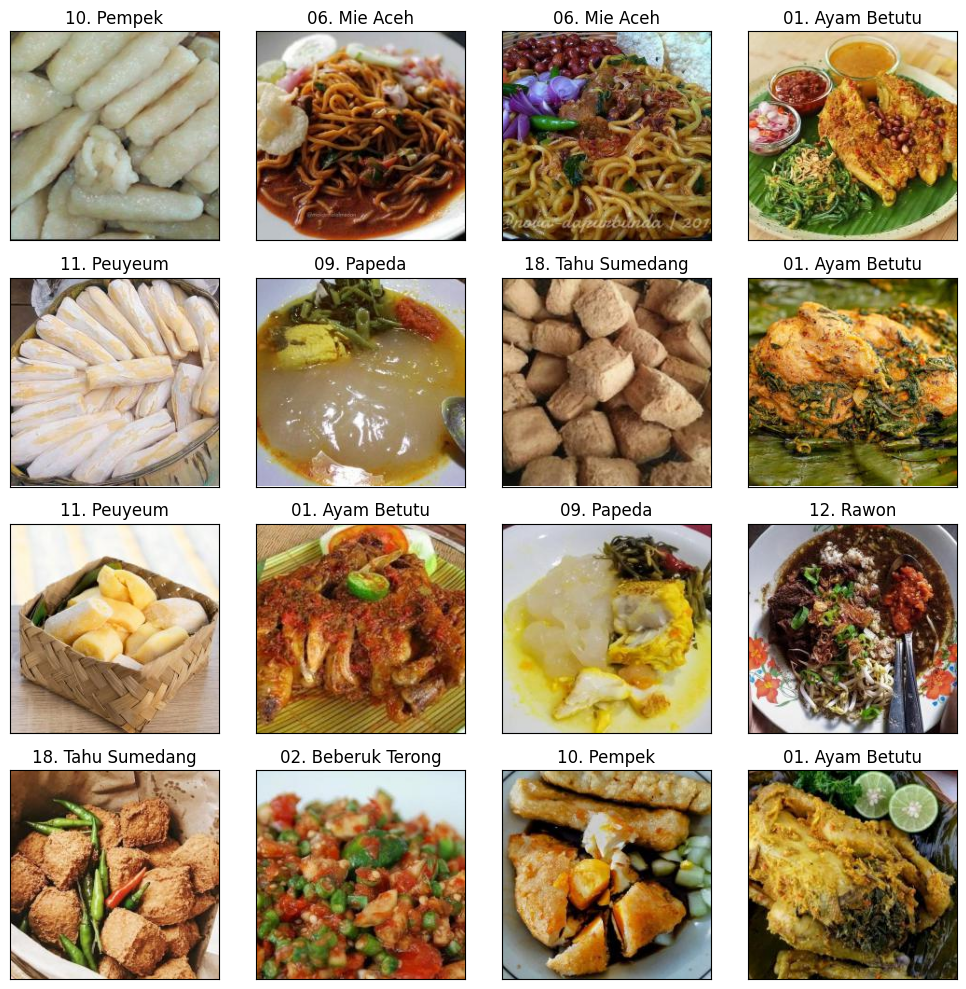

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
import cv2
from keras.preprocessing.image import ImageDataGenerator
import random

# This function computes the Error Level Analysis (ELA) of an image
def compute_ela_cv(path, quality):

    # Create temporary filename
    temp_filename = 'temp_filename.jpeg'

    # define the number of scales to use
    scales = 15

    # read original image
    orginal_img = cv2.imread(path)

    # convert the original image to RGB
    orginal_img = cv2.cvtColor(orginal_img, cv2.COLOR_BGR2RGB)

    # Save the original image with the specified JPEG quality
    cv2.imwrite(temp_filename, orginal_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # Multiply the absolute difference between the original and compressed photos by the scaling factor.
    diff = scales * cv2.absdiff(orginal_img, compressed_img)

    #return diff
    return diff

# this function converts an image to its ELA representation
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_filename.jpeg'
    ela_filename = 'temp_ela.png'

    # Open the image and convert it to RGB format
    image = Image.open(path).convert('RGB')

    # Save the image with the specified JPEG quality
    image.save(temp_filename, 'JPEG', quality = quality)

    # Open the temporary image and compute the difference between the original and compressed images
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)

    # determine the greatest difference between the pixels in the ELA image.
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])

# returns a random file with the provided extension from a directory.
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
    items = list(items)
    random_img = random.choice(items)
    return random_img.as_posix()

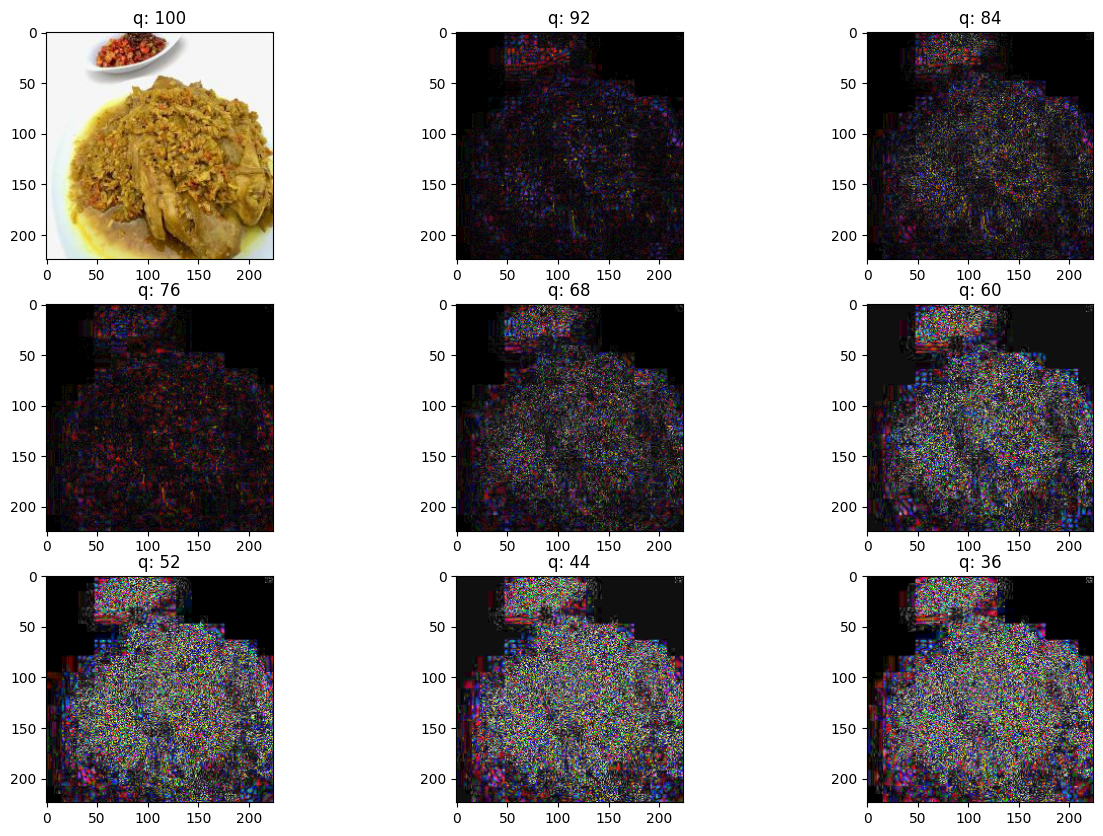

In [ ]:
# Get a random image from the dataset
random_img = random_sample('/content/Indonesian-Food-1/train/01. Ayam Betutu')
orginal_img = cv2.imread(random_img)
orginal_img = cv2.cvtColor(orginal_img, cv2.COLOR_BGR2RGB) / 255.0
# Set initial quality value and number of rows and columns for the plot
init = 100
columns = 3
rows = 3
# Create a plot to display the images
fig=plt.figure(figsize=(15, 10))
for i in range(1, columns * rows + 1):
    # Calculate the quality value for the current image
    quality = init - (i - 1) * 8
    # Apply the quality degradation effect to the image
    degraded_img = compute_ela_cv(path = random_img,quality = quality)
    if i == 1:
        degraded_img = orginal_img.copy()
    # Add the image to the plot
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(degraded_img)
plt.show()

In [ ]:
def create_dataframe(directory):
    filepaths = []
    labels = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Tambahkan ekstensi lain jika perlu
                filepath = os.path.join(root, filename)
                label = os.path.basename(root)  # Label adalah nama folder
                filepaths.append(filepath)
                labels.append(label)

    df = pd.DataFrame({
        'Filepath': filepaths,
        'Label': labels
    })
    return df

train_df = create_dataframe("/content/Indonesian-Food-1/train")
valid_df = create_dataframe("/content/Indonesian-Food-1/valid")
test_df = create_dataframe("/content/Indonesian-Food-1/test")

In [ ]:
import tensorflow as tf

data_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = data_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

#validation
val_images = data_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
#testing
test_images = data_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 635 validated image filenames belonging to 18 classes.
Found 179 validated image filenames belonging to 18 classes.
Found 89 validated image filenames belonging to 18 classes.


In [ ]:
# Resize Layer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(224,224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# Create checkpoint callback
checkpoint_path = "foods_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

12683000/12683000 [==============================] - 0s 0us/step


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-06-13 13:51:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-13 13:51:30 (63.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the input layer of the neural network model
input_layer_nn = pretrained_model.input

# resize and rescale the input images
rescaled_images_nn = resize_and_rescale(input_layer_nn)

# Add dense layers with ReLU activation and dropout regularization to the neural network model
dense_layer_1_nn = Dense(256, activation='relu')(pretrained_model.output)
dropout_layer_1_nn = Dropout(0.2)(dense_layer_1_nn)
dense_layer_2_nn = Dense(256, activation='relu')(dropout_layer_1_nn)
dropout_layer_2_nn = Dropout(0.2)(dense_layer_2_nn)

# Define the output layer of the neural network model with softmax activation
output_layer_nn = Dense(18, activation='softmax')(dropout_layer_2_nn)

# Define the neural network model with the input and output layers
model_nn = Model(inputs=input_layer_nn, outputs=output_layer_nn)

# Compile the neural network model with Adam optimizer, categorical crossentropy loss and accuracy metric
model_nn.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the nn model with the training and validation data, using early stopping, tensorboard and checkpoint callbacks
history_nn = model_nn.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "food_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/food_classification/20240613-135134
Epoch 1/100
20/20 [==============================] - 33s 1s/step - loss: 3.3316 - accuracy: 0.0646 - val_loss: 3.0693 - val_accuracy: 0.0838
Epoch 2/100
20/20 [==============================] - 25s 1s/step - loss: 3.1926 - accuracy: 0.0740 - val_loss: 2.9738 - val_accuracy: 0.1117
Epoch 3/100
20/20 [==============================] - 25s 1s/step - loss: 3.0751 - accuracy: 0.0803 - val_loss: 2.9019 - val_accuracy: 0.1397
Epoch 4/100
20/20 [==============================] - 29s 1s/step - loss: 3.0256 - accuracy: 0.1055 - val_loss: 2.8451 - val_accuracy: 0.1453
Epoch 5/100
20/20 [==============================] - 27s 1s/step - loss: 2.9895 - accuracy: 0.1039 - val_loss: 2.7946 - val_accuracy: 0.1844
Epoch 6/100
20/20 [==============================] - 26s 1s/step - loss: 2.8987 - accuracy: 0.1213 - val_loss: 2.7483 - val_accuracy: 0.1899
Epoch 7/100
20/20 [==============================] - 30s 2s/step - loss

    Test Loss: 0.73991
Test Accuracy: 87.64%


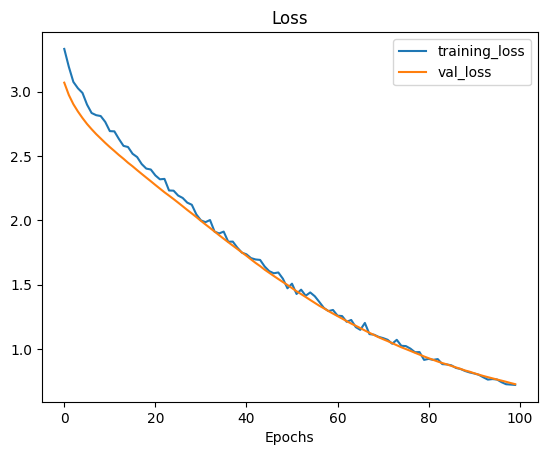

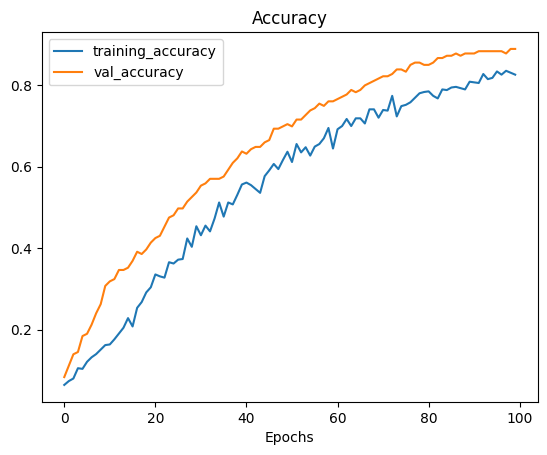

In [ ]:
# model evaluation
results = model_nn.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plot_loss_curves(history_nn)

In [ ]:
# Predict the label of the test_images
pred = model_nn.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

3/3 [==============================] - 4s 759ms/step


['10. Pempek',
 '10. Pempek',
 '18. Tahu Sumedang',
 '11. Peuyeum',
 '11. Peuyeum',
 '16. Soto Banjar',
 '03. Coto Makassar',
 '16. Soto Banjar',
 '02. Beberuk Terong',
 '02. Beberuk Terong',
 '02. Beberuk Terong',
 '02. Beberuk Terong',
 '14. Sate Madura',
 '14. Sate Madura',
 '14. Sate Madura',
 '14. Sate Madura',
 '14. Sate Madura',
 '14. Sate Madura',
 '14. Sate Madura',
 '14. Sate Madura',
 '14. Sate Madura',
 '01. Ayam Betutu',
 '07. Nasi Kuning',
 '01. Ayam Betutu',
 '07. Nasi Kuning',
 '15. Serabi',
 '15. Serabi',
 '15. Serabi',
 '15. Serabi',
 '15. Serabi',
 '15. Serabi',
 '09. Papeda',
 '17. Soto Lamongan',
 '17. Soto Lamongan',
 '16. Soto Banjar',
 '17. Soto Lamongan',
 '17. Soto Lamongan',
 '17. Soto Lamongan',
 '12. Rawon',
 '12. Rawon',
 '12. Rawon',
 '13. Rendang',
 '12. Rawon',
 '08. Nasi Pecel',
 '08. Nasi Pecel',
 '08. Nasi Pecel',
 '01. Ayam Betutu',
 '08. Nasi Pecel',
 '08. Nasi Pecel',
 '08. Nasi Pecel',
 '13. Rendang',
 '13. Rendang',
 '05. Kerak Telor',
 '13. Ren

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
def output(location):
    img = load_img(location,target_size=(224,224,3))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,[0])
    answer = model_nn.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
img = output('/content/Indonesian-Food-1/test/11. Peuyeum/Peuyeum-30_jpg.rf.b4da9e2c1b75958f8aba4f3afe0b906c.jpg')
img

1/1 [==============================] - 2s 2s/step


'09. Papeda'

In [ ]:
# predict the label of the test_images
pred = model_nn.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

3/3 [==============================] - 3s 1s/step
The first 5 predictions: ['10. Pempek', '10. Pempek', '18. Tahu Sumedang', '11. Peuyeum', '11. Peuyeum']


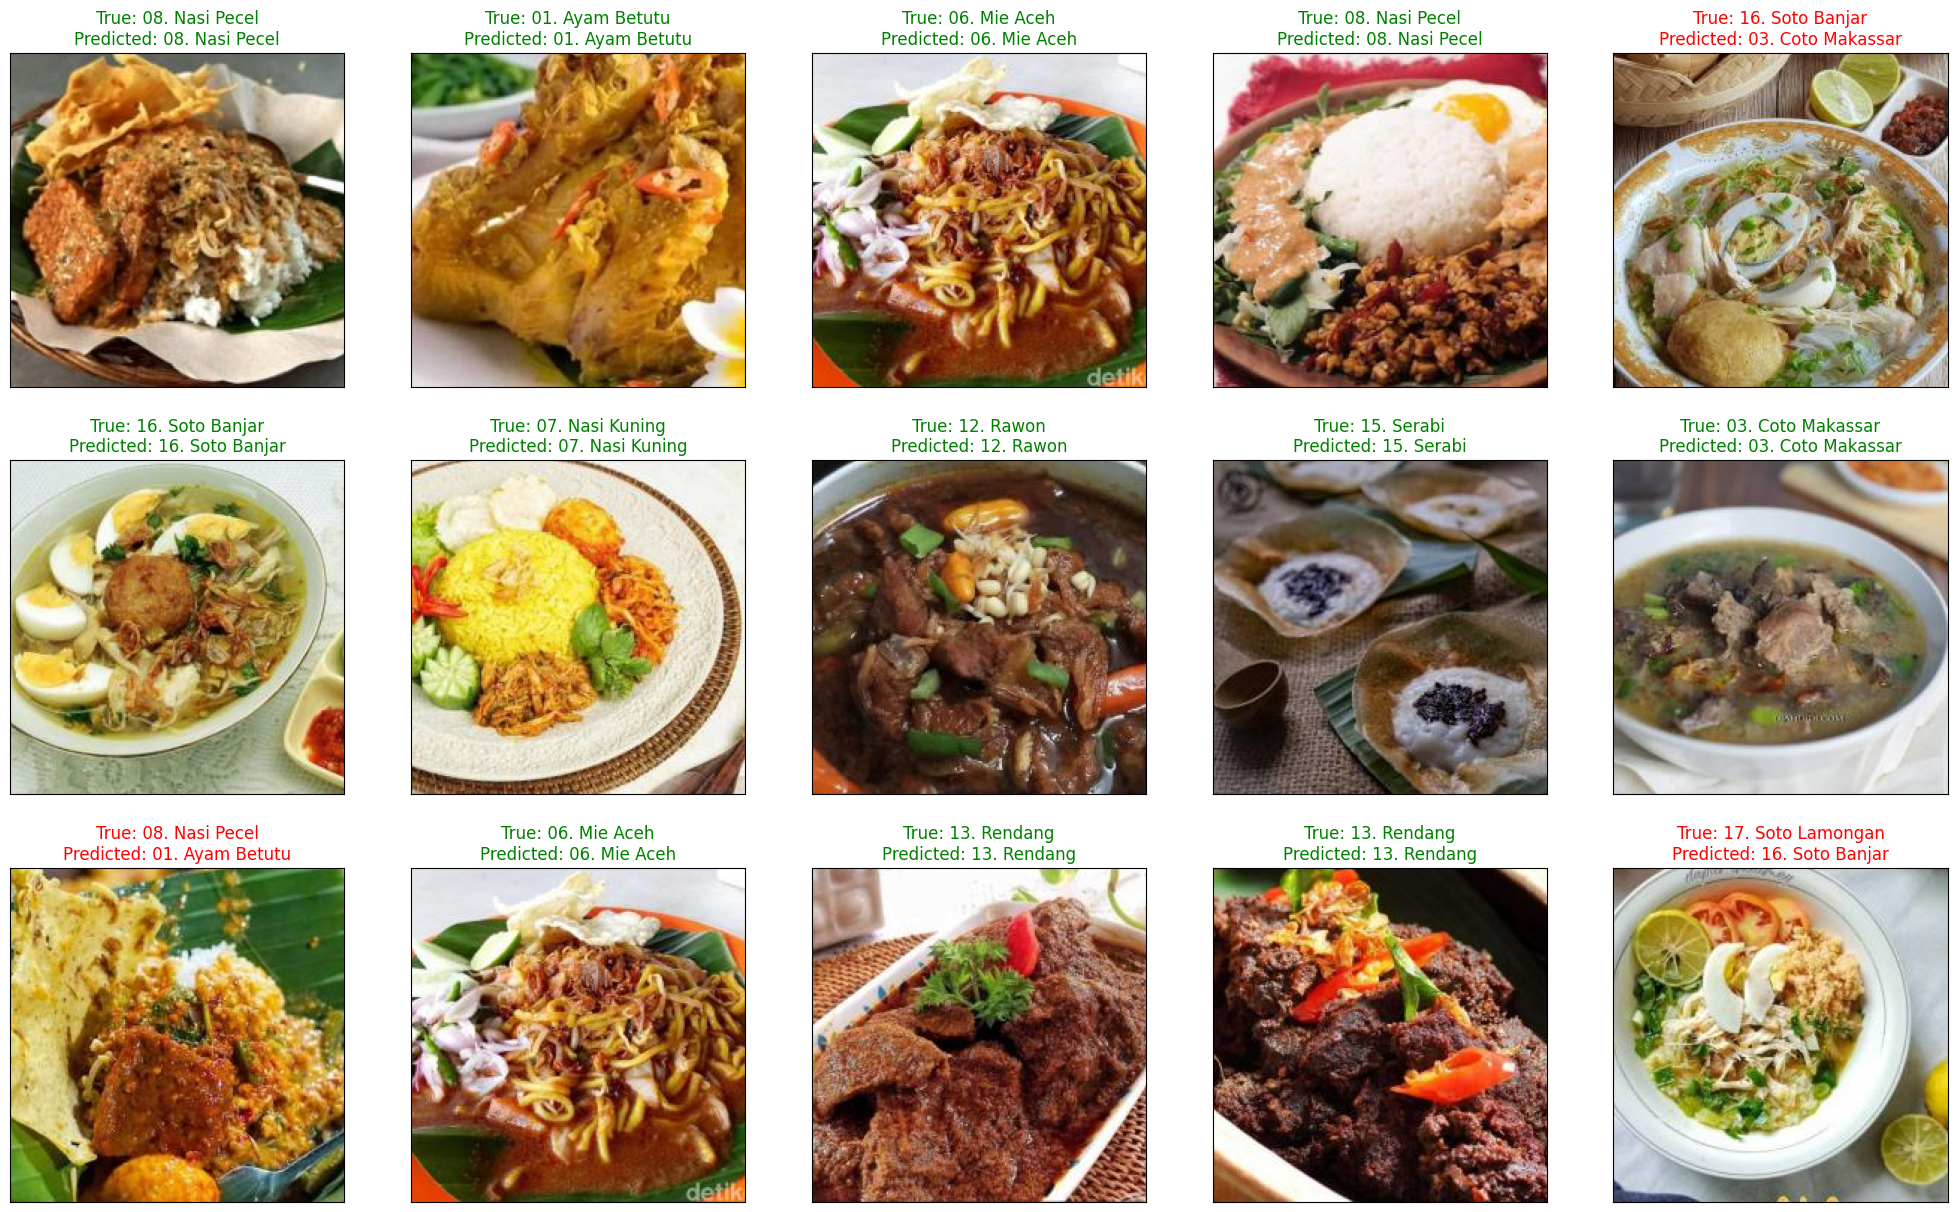

                    precision    recall  f1-score   support

   01. Ayam Betutu       0.70      0.88      0.78         8
02. Beberuk Terong       1.00      1.00      1.00         4
 03. Coto Makassar       0.75      1.00      0.86         3
         04. Gudeg       1.00      1.00      1.00         5
   05. Kerak Telor       0.75      1.00      0.86         3
      06. Mie Aceh       1.00      1.00      1.00         4
   07. Nasi Kuning       1.00      0.50      0.67         4
    08. Nasi Pecel       1.00      0.86      0.92         7
        09. Papeda       0.75      1.00      0.86         3
        10. Pempek       0.67      1.00      0.80         4
       11. Peuyeum       1.00      1.00      1.00         2
         12. Rawon       1.00      0.80      0.89         5
       13. Rendang       0.80      0.89      0.84         9
   14. Sate Madura       1.00      1.00      1.00         9
        15. Serabi       1.00      0.86      0.92         7
   16. Soto Banjar       0.67      0.67

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import classification_report
# display some random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3,
                         ncols=5,
                         figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
# shows classification report
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score    support
01. Ayam Betutu      0.700000  0.875000  0.777778   8.000000
02. Beberuk Terong   1.000000  1.000000  1.000000   4.000000
03. Coto Makassar    0.750000  1.000000  0.857143   3.000000
04. Gudeg            1.000000  1.000000  1.000000   5.000000
05. Kerak Telor      0.750000  1.000000  0.857143   3.000000
06. Mie Aceh         1.000000  1.000000  1.000000   4.000000
07. Nasi Kuning      1.000000  0.500000  0.666667   4.000000
08. Nasi Pecel       1.000000  0.857143  0.923077   7.000000
09. Papeda           0.750000  1.000000  0.857143   3.000000
10. Pempek           0.666667  1.000000  0.800000   4.000000
11. Peuyeum          1.000000  1.000000  1.000000   2.000000
12. Rawon            1.000000  0.800000  0.888889   5.000000
13. Rendang          0.800000  0.888889  0.842105   9.000000
14. Sate Madura      1.000000  1.000000  1.000000   9.000000
15. Serabi           1.000000  0.857143  0.923077   7.000000
16. Soto Banjar      0.666667  0.666667  0.666667   3.000000
17. Soto Lamongan    1.000000  0.833333  0.909091   6.000000
18. Tahu Sumedang    1.000000  0.333333  0.500000   3.000000
accuracy             0.876404  0.876404  0.876404   0.876404
macro avg            0.893519  0.867306  0.859377  89.000000
weighted avg         0.901311  0.876404  0.873081  89.000000

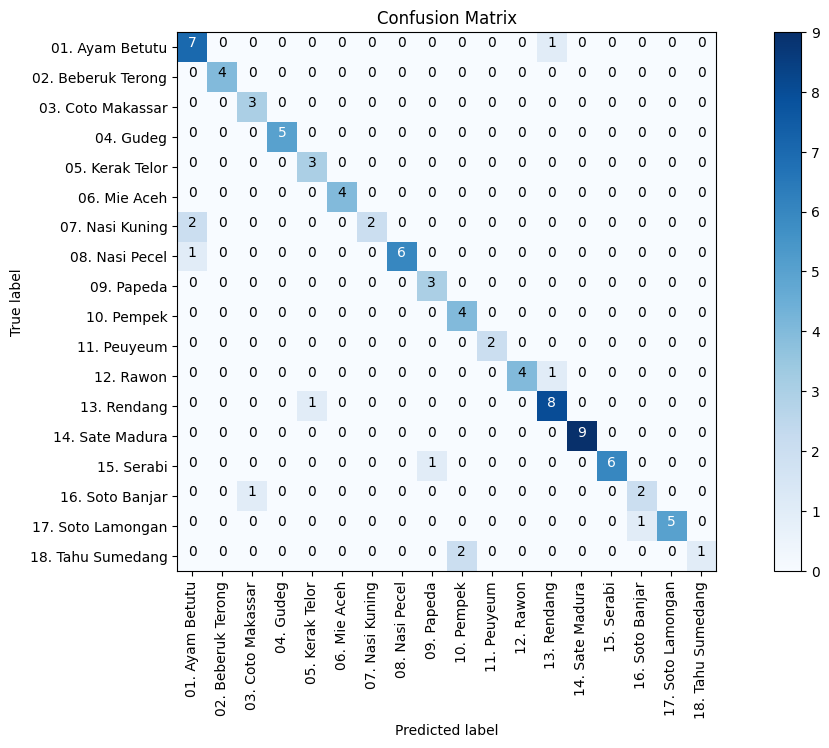

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def make_confusion_matrix(y_true,
                          y_pred,
                          classes=None,
                          figsize=(15, 7),
                          text_size=10,
                          norm=False,
                          savefig=False):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)

    # colors will represent how correct a class is, darker means better
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),

        # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels,

        # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # added rotate xticks for readability & increase font size
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

# show the graphic
make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
#Save the trained model as a Keras HDF5 file.

saved_model_path = "./my_model.h5"
model_nn.save(saved_model_path)

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [ ]:
# convert model to tflite model
model = tf.keras.models.load_model('my_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("food_detection.tflite", "wb").write(tflite_model)

13158448

In [ ]:
saved_model_path = "./my_model.h5"
model_json = model.to_json()

with open('model.json', 'w') as json_file:
    json_file.write(model_json)

print("Model saved to model.json")

Model saved to model.json


In [ ]:
print(train_images[0][0].shape)


(32, 224, 224, 3)


In [ ]:
print(train_images[0][1].shape)


(32, 18)
